In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import networkx as nx
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import community as community_louvain
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [47]:
# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [48]:
# Function to parse DBLP XML file and create co-authorship network
def parse_dblp_xml(xml_path, max_publications=20000, chunk_size=100000):
    """
    Parse the DBLP XML file and create a co-authorship network
    Uses a memory-efficient approach by limiting the total publications processed
    
    Parameters:
    - xml_path: Path to the DBLP XML file
    - max_publications: Maximum number of publications to process (default: 1000)
    - chunk_size: Number of lines to read in each chunk
    
    Returns:
    - G: NetworkX graph of co-authorship network
    - author_papers: Dictionary of authors and their papers
    """
    print(f"Parsing DBLP XML file with a limit of {max_publications} publications...")
    
    # Initialize data structures
    author_papers = defaultdict(list)
    coauthorship = defaultdict(lambda: defaultdict(int))
    
    # Function to parse a chunk of XML lines until we reach max_publications
    def parse_chunk(lines, current_count):
        """Parse a chunk of XML lines and update the co-authorship network"""
        current_article = None
        current_authors = []
        in_author_tag = False
        author_text = ""
        pub_count = 0
        
        for line in lines:
            # Check if we've reached the maximum publications
            if current_count + pub_count >= max_publications:
                break
                
            # Check for article/publication start
            if "<article " in line or "<book " in line or "<inproceedings " in line:
                # Extract key if available
                key_start = line.find('key="')
                if key_start != -1:
                    key_end = line.find('"', key_start + 5)
                    if key_end != -1:
                        current_article = line[key_start + 5:key_end]
                current_authors = []
            
            # Check for author tag
            elif "<author>" in line:
                in_author_tag = True
                parts = line.split("<author>")
                if len(parts) > 1:
                    author_text = parts[1]
                    if "</author>" in author_text:
                        author_text = author_text.split("</author>")[0].strip()
                        if author_text:
                            current_authors.append(author_text)
                        in_author_tag = False
            
            # Continue collecting author text if we're in an author tag
            elif in_author_tag:
                if "</author>" in line:
                    author_text += line.split("</author>")[0].strip()
                    if author_text:
                        current_authors.append(author_text)
                    in_author_tag = False
                else:
                    author_text += line.strip()
            
            # Check for end of publication
            elif "</article>" in line or "</book>" in line or "</inproceedings>" in line:
                if current_article and current_authors:
                    pub_count += 1
                    
                    # Add paper to each author's list
                    for author in current_authors:
                        author_papers[author].append(current_article)
                    
                    # Update co-authorship network
                    for i, author1 in enumerate(current_authors):
                        for author2 in current_authors[i+1:]:
                            coauthorship[author1][author2] += 1
                            coauthorship[author2][author1] += 1
                
                # Reset current article
                current_article = None
                current_authors = []
        
        return pub_count
    
    try:
        # Process file in chunks until we hit max_publications
        pub_count = 0
        chunk_idx = 0
        
        with open(xml_path, 'r', encoding='utf-8', errors='ignore') as f:
            while pub_count < max_publications:
                # Read chunk
                chunk_lines = []
                for _ in range(chunk_size):
                    line = f.readline()
                    if not line:
                        break
                    chunk_lines.append(line)
                
                if not chunk_lines:
                    # End of file
                    break
                
                # Process chunk
                chunk_idx += 1
                print(f"Processing chunk {chunk_idx} (publications so far: {pub_count}/{max_publications})")
                new_pubs = parse_chunk(chunk_lines, pub_count)
                pub_count += new_pubs
                
                # Check if we've processed enough publications
                if pub_count >= max_publications:
                    print(f"Reached limit of {max_publications} publications")
                    break
        
        print(f"Processed {pub_count} publications from {chunk_idx} chunks")
    
    except Exception as e:
        print(f"Error parsing XML: {e}")
        print("Returning partial results")
    
    print(f"Found {len(author_papers)} unique authors in the sample")
    
    # Create NetworkX graph with memory-efficient approach
    print("Building graph (this may take a moment)...")
    G = nx.Graph()
    
    # Add nodes and edges in batches to reduce memory usage
    node_count = 0
    edge_count = 0
    batch_size = 1000
    
    # Add nodes
    author_list = list(author_papers.keys())
    for i in range(0, len(author_list), batch_size):
        batch = author_list[i:i+batch_size]
        G.add_nodes_from(batch)
        node_count += len(batch)
        
        # Periodic progress update
        if (i // batch_size) % 10 == 0:
            print(f"Added {node_count} nodes to graph")
    
    # Add edges
    edge_batch = []
    for author1, collaborators in coauthorship.items():
        for author2, weight in collaborators.items():
            edge_batch.append((author1, author2, {'weight': weight}))
            
            # Process batch when it reaches batch_size
            if len(edge_batch) >= batch_size:
                G.add_edges_from(edge_batch)
                edge_count += len(edge_batch)
                edge_batch = []
                
                # Periodic progress update
                if edge_count % (batch_size * 10) == 0:
                    print(f"Added {edge_count} edges to graph")
    
    # Add any remaining edges
    if edge_batch:
        G.add_edges_from(edge_batch)
        edge_count += len(edge_batch)
    
    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    return G, author_papers

In [49]:
# 1. Parse DBLP XML file
xml_path = "/kaggle/input/dblp2023/dblp.xml"  # Update with your file path
G, author_papers = parse_dblp_xml(xml_path)

Parsing DBLP XML file with a limit of 20000 publications...
Processing chunk 1 (publications so far: 0/20000)
Processing chunk 2 (publications so far: 23/20000)
Processing chunk 3 (publications so far: 23/20000)
Processing chunk 4 (publications so far: 432/20000)
Processing chunk 5 (publications so far: 1540/20000)
Processing chunk 6 (publications so far: 3097/20000)
Processing chunk 7 (publications so far: 4213/20000)
Processing chunk 8 (publications so far: 5209/20000)
Processing chunk 9 (publications so far: 5530/20000)
Processing chunk 10 (publications so far: 5910/20000)
Processing chunk 11 (publications so far: 7197/20000)
Processing chunk 12 (publications so far: 8515/20000)
Processing chunk 13 (publications so far: 10225/20000)
Processing chunk 14 (publications so far: 11651/20000)
Processing chunk 15 (publications so far: 12568/20000)
Processing chunk 16 (publications so far: 14265/20000)
Processing chunk 17 (publications so far: 15446/20000)
Processing chunk 18 (publications 

In [50]:
# Function to filter the graph to include only authors with sufficient connections
def filter_graph(G, min_collaborations=1):
    """
    Filter the graph to remove authors with too few collaborations
    """
    # Create a new graph with the filtered nodes
    H = G.copy()
    
    # Remove nodes with degree less than min_collaborations
    nodes_to_remove = [node for node, degree in dict(H.degree()).items() if degree < min_collaborations]
    H.remove_nodes_from(nodes_to_remove)
    
    # Get the largest connected component
    largest_cc = max(nx.connected_components(H), key=len)
    H = H.subgraph(largest_cc).copy()
    
    print(f"Filtered graph has {H.number_of_nodes()} nodes and {H.number_of_edges()} edges")
    
    return H

In [51]:
# 2. Filter the graph to get a manageable size
G_filtered = filter_graph(G, min_collaborations=2)

Filtered graph has 7254 nodes and 18327 edges


In [52]:
# Function to extract features from the graph
def extract_features(G):
    """
    Extract node features from the graph
    """
    # Calculate various centrality measures
    print("Extracting graph features...")
    
    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    
    # Betweenness centrality (can be slow for large graphs)
    betweenness_centrality = {}
    if G.number_of_nodes() <= 1000:
        betweenness_centrality = nx.betweenness_centrality(G, k=min(100, G.number_of_nodes()))
    else:
        # For larger graphs, use approximate betweenness with sampling
        betweenness_centrality = nx.betweenness_centrality(G, k=100)
    
    # Eigenvector centrality
    eigenvector_centrality = {}
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=100)
    except:
        print("Eigenvector centrality calculation did not converge. Using degree centrality instead.")
        eigenvector_centrality = degree_centrality
    
    # Clustering coefficient
    clustering_coefficient = nx.clustering(G)
    
    # Create a DataFrame with the node features
    node_features = pd.DataFrame({
        'degree_centrality': pd.Series(degree_centrality),
        'betweenness_centrality': pd.Series(betweenness_centrality),
        'eigenvector_centrality': pd.Series(eigenvector_centrality),
        'clustering_coefficient': pd.Series(clustering_coefficient)
    })
    
    # Fill any missing values with zeros
    node_features.fillna(0, inplace=True)
    
    print(f"Extracted features for {len(node_features)} nodes")
    
    return node_features

In [53]:
# 3. Extract graph features
node_features = extract_features(G_filtered)

Extracting graph features...
Eigenvector centrality calculation did not converge. Using degree centrality instead.
Extracted features for 7254 nodes


Creating feature correlation heatmap...


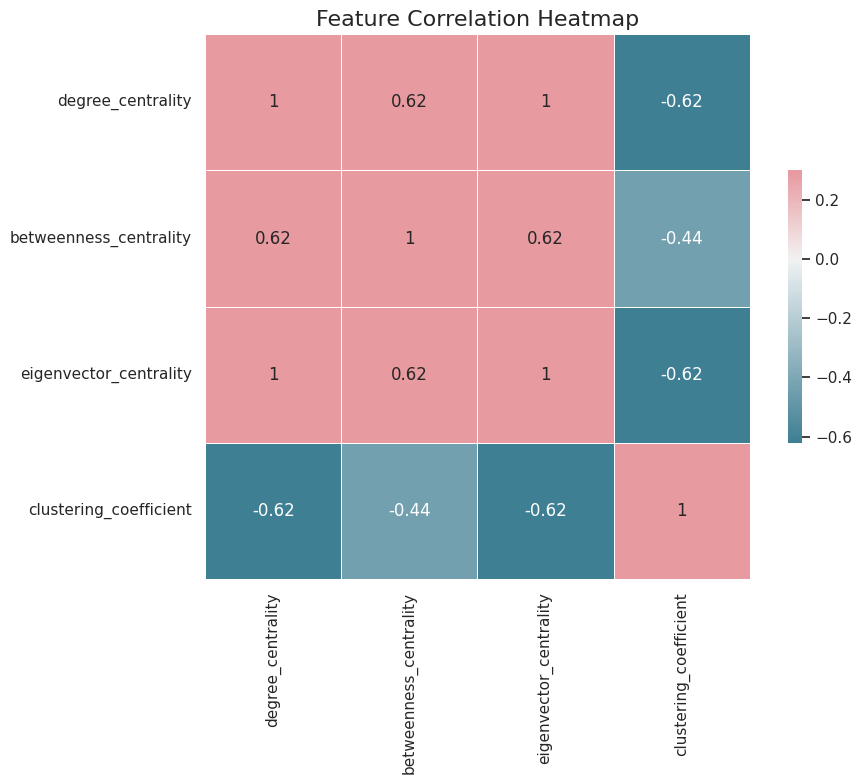

In [54]:
# 2. Feature correlation heatmap
def visualize_feature_correlations(node_features):
    """
    Create a heatmap showing correlations between node features
    """
    print("Creating feature correlation heatmap...")
    
    # Calculate correlation matrix
    corr = node_features.corr()
    
    # Set up the figure
    plt.figure(figsize=(10, 8))
    
    # Create a custom colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Create the heatmap
    sns.heatmap(corr, annot=True, cmap=cmap, vmax=.3, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.title('Feature Correlation Heatmap', fontsize=16)
    plt.tight_layout()
    plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
visualize_feature_correlations(node_features)

In [55]:
# Function to create adjacency matrix
def create_adjacency_matrix(G):
    """
    Create adjacency matrix from graph
    """
    # Get list of nodes
    nodes = list(G.nodes())
    
    # Create mapping from node to index
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    # Create adjacency matrix
    n = len(nodes)
    adj_matrix = np.zeros((n, n))
    
    # Fill adjacency matrix
    for u, v, data in G.edges(data=True):
        i, j = node_to_idx[u], node_to_idx[v]
        adj_matrix[i, j] = data.get('weight', 1)
        adj_matrix[j, i] = data.get('weight', 1)  # Undirected graph
    
    return adj_matrix, nodes

In [56]:
# Apply spectral clustering
def apply_spectral_clustering(G, n_clusters=5):
    """
    Apply spectral clustering to the graph
    """
    print(f"Applying spectral clustering with {n_clusters} clusters...")
    
    # Create adjacency matrix
    adj_matrix, nodes = create_adjacency_matrix(G)
    
    # Normalize adjacency matrix
    adj_norm = normalize(adj_matrix, norm='l1', axis=1)
    
    # Apply spectral clustering
    sc = SpectralClustering(n_clusters=n_clusters, 
                           affinity='precomputed',
                           assign_labels='kmeans',
                           random_state=42)
    
    labels = sc.fit_predict(adj_norm)
    
    # Create a dictionary mapping nodes to cluster labels
    node_to_cluster = {node: label for node, label in zip(nodes, labels)}
    
    # Add cluster labels to the graph
    nx.set_node_attributes(G, node_to_cluster, 'spectral_cluster')
    
    return node_to_cluster, labels

In [57]:
# 5. Apply spectral clustering
spectral_clusters, spectral_labels = apply_spectral_clustering(G_filtered, n_clusters=10)

Applying spectral clustering with 10 clusters...


In [58]:
# Apply community detection using Louvain algorithm
def apply_louvain_community_detection(G):
    """
    Apply Louvain community detection algorithm
    """
    print("Applying Louvain community detection...")
    
    # Apply Louvain algorithm
    communities = community_louvain.best_partition(G)
    
    # Add community labels to the graph
    nx.set_node_attributes(G, communities, 'louvain_community')
    
    # Count the number of communities
    n_communities = len(set(communities.values()))
    print(f"Found {n_communities} communities using Louvain algorithm")
    
    return communities

In [59]:
# 4. Apply Louvain community detection
louvain_communities = apply_louvain_community_detection(G_filtered)

Applying Louvain community detection...
Found 84 communities using Louvain algorithm


In [60]:
# Apply Gaussian Mixture Model (GMM) clustering
def apply_gmm_clustering(node_features, n_clusters=5):
    """
    Apply Gaussian Mixture Model clustering to node features
    """
    print(f"Applying GMM clustering with {n_clusters} clusters...")
    
    # Normalize features
    X = node_features.values
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    # Apply GMM
    gmm = GaussianMixture(n_components=n_clusters,
                         covariance_type='full',
                         random_state=42,
                         max_iter=100)
    
    # Get cluster labels
    labels = gmm.fit_predict(X)
    
    # Create a dictionary mapping nodes to cluster labels
    node_to_cluster = {node: label for node, label in zip(node_features.index, labels)}
    
    return node_to_cluster, labels

In [61]:
# Apply dimensionality reduction using PCA
def apply_pca(node_features, n_components=2):
    """
    Apply PCA to node features
    """
    print(f"Applying PCA with {n_components} components...")
    
    # Normalize features
    X = node_features.values
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    # Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)
    
    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance}")
    
    return X_pca, explained_variance

In [62]:
# Apply t-SNE for dimensionality reduction
def apply_tsne(node_features, perplexity=30, n_components=2):
    """
    Apply t-SNE to node features
    """
    print(f"Applying t-SNE with {n_components} components...")
    
    # Normalize features
    X = node_features.values
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    # Apply t-SNE
    tsne = TSNE(n_components=n_components, 
                perplexity=min(perplexity, len(X)-1),
                learning_rate='auto',
                init='pca',
                random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    return X_tsne

In [63]:
# Function to visualize clusters in 2D
def visualize_clusters(X_reduced, labels, method='PCA', figsize=(12, 10)):
    """
    Visualize clusters in 2D
    """
    # Create a DataFrame with the reduced data and labels
    df = pd.DataFrame({
        'x': X_reduced[:, 0],
        'y': X_reduced[:, 1],
        'cluster': labels
    })
    
    # Plot clusters
    plt.figure(figsize=figsize)
    sns.scatterplot(x='x', y='y', hue='cluster', data=df, palette='viridis', alpha=0.7)
    plt.title(f'Cluster Visualization using {method}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [64]:
# Function to visualize the graph with community colors
def visualize_network(G, node_to_cluster, figsize=(12, 10), max_nodes=500):
    """
    Visualize the network with community colors
    If the graph is large, only visualize a subset of nodes
    """
    if G.number_of_nodes() > max_nodes:
        # Sample a subset of nodes
        sampled_nodes = list(G.nodes())[:max_nodes]
        G_vis = G.subgraph(sampled_nodes).copy()
        print(f"Visualizing a subgraph with {G_vis.number_of_nodes()} nodes")
    else:
        G_vis = G.copy()
    
    # Get position using spring layout
    pos = nx.spring_layout(G_vis, seed=42)
    
    # Plot the graph
    plt.figure(figsize=figsize)
    
    # Filter node_to_cluster to only include nodes in G_vis
    filtered_node_to_cluster = {node: cluster for node, cluster in node_to_cluster.items() if node in G_vis}
    
    # Convert cluster labels to list following node order
    colors = [filtered_node_to_cluster.get(node, 0) for node in G_vis.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G_vis, pos, node_color=colors, cmap=plt.cm.viridis, 
                          node_size=50, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G_vis, pos, alpha=0.2)
    
    plt.title('DBLP Co-authorship Network Communities')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [65]:
# Function to evaluate clustering quality
def evaluate_clustering(node_features, labels):
    """
    Evaluate clustering quality using silhouette score
    """
    # Normalize features
    X = node_features.values
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    # Calculate silhouette score
    silhouette = silhouette_score(X, labels)
    print(f"Silhouette Score: {silhouette:.4f}")
    
    return silhouette


In [66]:
# Function to find influential authors in each community
def find_influential_authors(G, communities, top_n=5):
    """
    Find the most influential authors in each community
    """
    # Group nodes by community
    community_nodes = defaultdict(list)
    for node, community in communities.items():
        community_nodes[community].append(node)
    
    # Calculate node influence using degree centrality
    centrality = nx.degree_centrality(G)
    
    # Find top authors in each community
    influential_authors = {}
    for community, nodes in community_nodes.items():
        # Sort nodes by centrality
        sorted_nodes = sorted(nodes, key=lambda x: centrality.get(x, 0), reverse=True)
        
        # Take top N nodes
        influential_authors[community] = sorted_nodes[:top_n]
    
    return influential_authors

In [67]:
# 6. Apply GMM clustering
gmm_clusters, gmm_labels = apply_gmm_clustering(node_features, n_clusters=10)

# 7. Evaluate clustering methods
print("\nEvaluating Clustering Methods:")
print("Spectral Clustering:")
evaluate_clustering(node_features, list(spectral_clusters.values()))

print("\nGMM Clustering:")
evaluate_clustering(node_features, gmm_labels)

Applying GMM clustering with 10 clusters...

Evaluating Clustering Methods:
Spectral Clustering:
Silhouette Score: -0.1927

GMM Clustering:
Silhouette Score: 0.3008


0.3007510919582102

Applying PCA with 2 components...
Explained variance ratio: [0.74646803 0.1409813 ]

Visualizing spectral clusters:


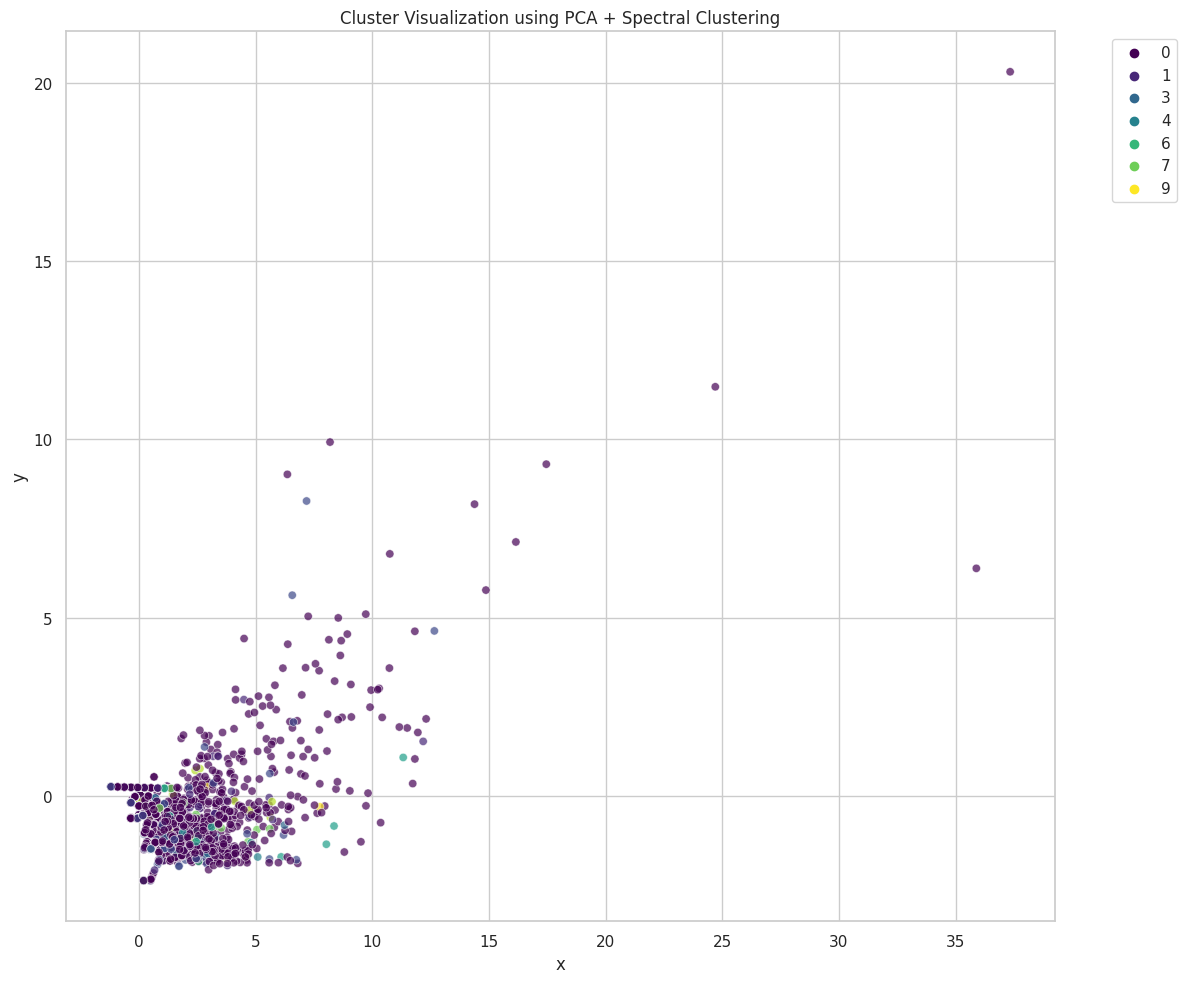

In [68]:
# 8. Apply dimensionality reduction for visualization
X_pca, explained_variance = apply_pca(node_features, n_components=2)

# 9. Visualize clusters using PCA
print("\nVisualizing spectral clusters:")
visualize_clusters(X_pca, list(spectral_clusters.values()), method='PCA + Spectral Clustering')



Visualizing GMM clusters:


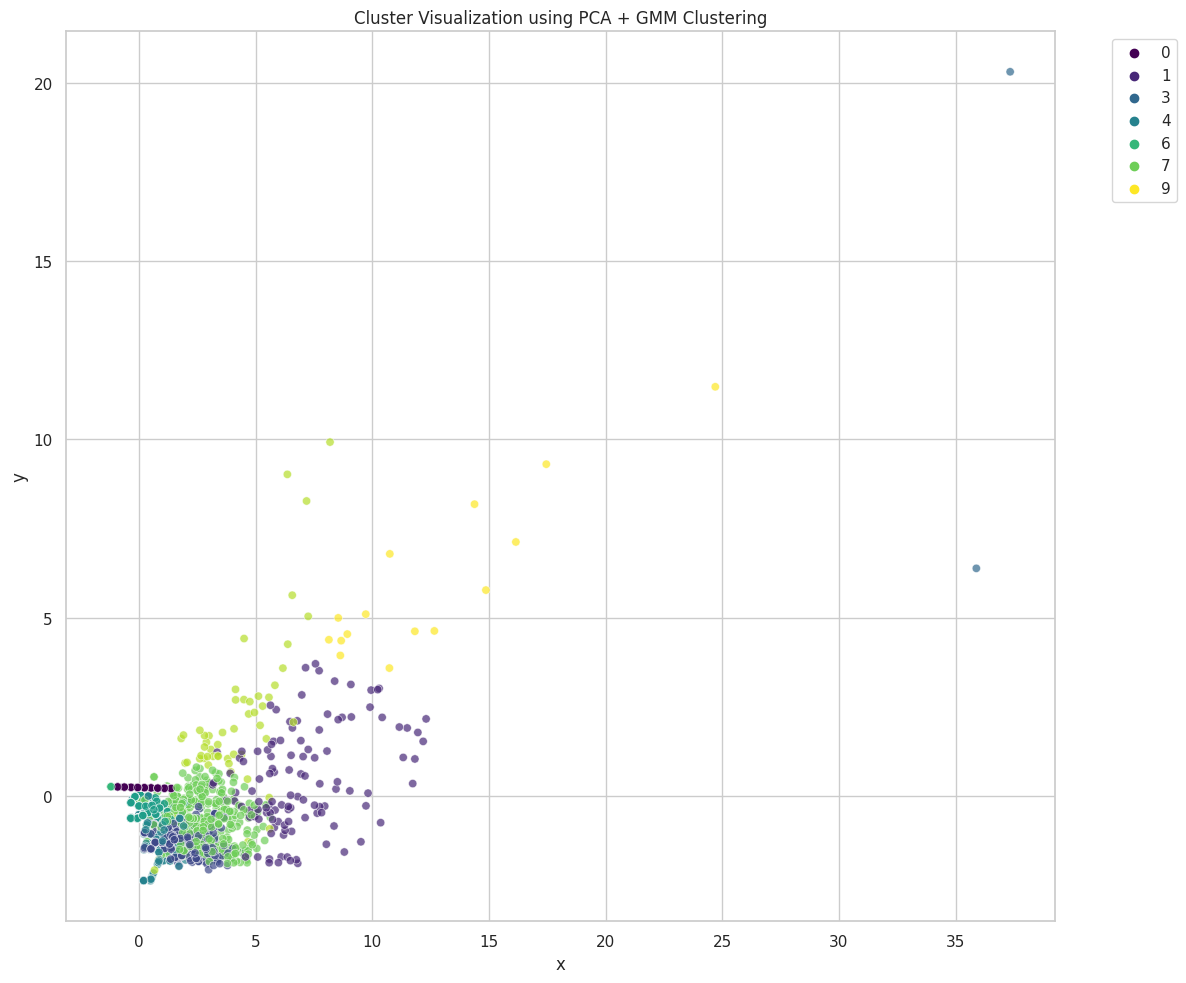

In [69]:
print("\nVisualizing GMM clusters:")
visualize_clusters(X_pca, gmm_labels, method='PCA + GMM Clustering')

In [70]:
# 10. If the graph is not too large, apply t-SNE
if G_filtered.number_of_nodes() <= 5000:
    X_tsne = apply_tsne(node_features, perplexity=min(30, G_filtered.number_of_nodes()-1))
    
    print("\nVisualizing clusters with t-SNE:")
    visualize_clusters(X_tsne, list(spectral_clusters.values()), method='t-SNE + Spectral Clustering')


Visualizing the network:
Visualizing a subgraph with 500 nodes


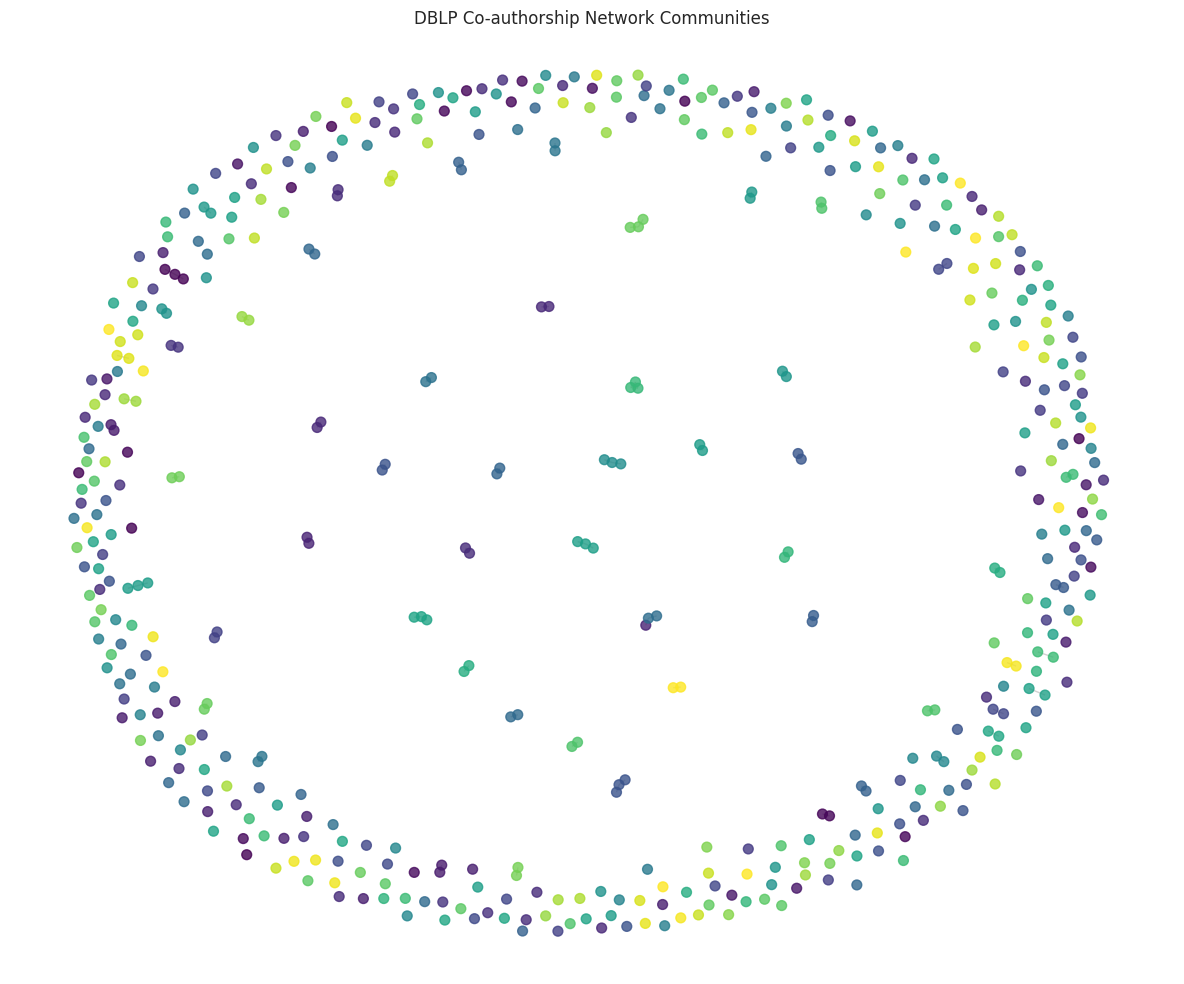

In [71]:
# 11. Visualize the network with community colors
print("\nVisualizing the network:")
visualize_network(G_filtered, louvain_communities)


In [72]:
# 12. Find influential authors in each community
print("\nFinding influential authors in each community:")
influential_authors = find_influential_authors(G_filtered, louvain_communities, top_n=5)


Finding influential authors in each community:


In [73]:
# 13. Print influential authors
for community, authors in sorted(influential_authors.items())[:5]:  # Only show top 5 communities
    print(f"\nCommunity {community}:")
    for author in authors:
        print(f"  - {author}")




Community 0:
  - Li Gu
  - Kun Ding
  - Xue Han
  - V. Roshan Joseph
  - Wei Hu

Community 1:
  - Peng Wang
  - Jing Chen
  - Jianxi Fan
  - Xiaoyan Li
  - Cheng-Kuan Lin

Community 2:
  - Yi Wang
  - Yang Xiang
  - Mohsen Guizani
  - Jing Huang
  - Hsiao-Hwa Chen

Community 3:
  - Lei Wang
  - Jie Li
  - Bijan Davvaz
  - Xigang Yuan
  - Xiangtao Li

Community 4:
  - Hui Li
  - Guangyuan Kan
  - Xiaoyan He
  - Liuqian Ding
  - Jiren Li


Creating comparative visualization of clustering methods...


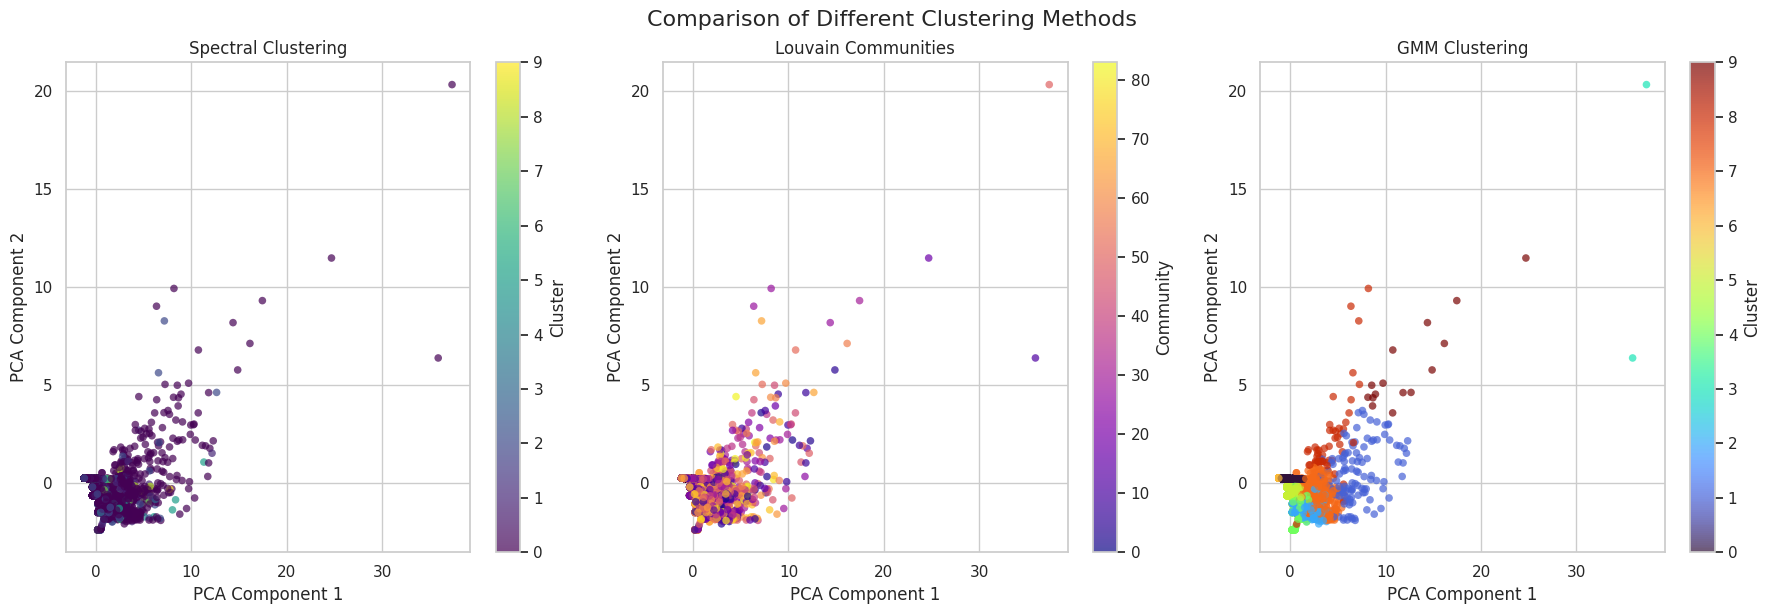


Clustering Agreement Metrics:
Adjusted Rand Index (Spectral vs Louvain): 0.0130
Adjusted Rand Index (Spectral vs GMM): 0.0207
Adjusted Rand Index (Louvain vs GMM): -0.0001
Normalized Mutual Info (Spectral vs Louvain): 0.3074
Normalized Mutual Info (Spectral vs GMM): 0.0138
Normalized Mutual Info (Louvain vs GMM): 0.0264


In [74]:
# 1. Comparative visualization showing multiple clustering results 
def compare_clustering_results(G, node_features, spectral_clusters, louvain_communities, gmm_clusters):
    """
    Create a side-by-side comparison of clustering results using PCA projection
    """
    print("Creating comparative visualization of clustering methods...")
    
    # Get node list
    nodes = list(G.nodes())
    
    # Apply PCA for visualization
    X = node_features.values
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    # Create a dataframe for plotting
    df = pd.DataFrame({
        'x': X_pca[:, 0],
        'y': X_pca[:, 1],
        'node': node_features.index,
        'spectral': [spectral_clusters.get(node, -1) for node in node_features.index],
        'louvain': [louvain_communities.get(node, -1) for node in node_features.index],
        'gmm': [gmm_clusters.get(node, -1) for node in node_features.index]
    })
    
    # Set up the figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot spectral clustering
    scatter1 = axs[0].scatter(df['x'], df['y'], c=df['spectral'], cmap='viridis', 
                            alpha=0.7, s=30, edgecolor='none')
    axs[0].set_title('Spectral Clustering')
    axs[0].set_xlabel('PCA Component 1')
    axs[0].set_ylabel('PCA Component 2')
    
    # Plot Louvain communities
    scatter2 = axs[1].scatter(df['x'], df['y'], c=df['louvain'], cmap='plasma', 
                            alpha=0.7, s=30, edgecolor='none')
    axs[1].set_title('Louvain Communities')
    axs[1].set_xlabel('PCA Component 1')
    axs[1].set_ylabel('PCA Component 2')
    
    # Plot GMM clustering
    scatter3 = axs[2].scatter(df['x'], df['y'], c=df['gmm'], cmap='turbo', 
                            alpha=0.7, s=30, edgecolor='none')
    axs[2].set_title('GMM Clustering')
    axs[2].set_xlabel('PCA Component 1')
    axs[2].set_ylabel('PCA Component 2')
    
    # Add colorbars
    plt.colorbar(scatter1, ax=axs[0], label='Cluster')
    plt.colorbar(scatter2, ax=axs[1], label='Community')
    plt.colorbar(scatter3, ax=axs[2], label='Cluster')
    
    plt.tight_layout()
    plt.suptitle('Comparison of Different Clustering Methods', y=1.02, fontsize=16)
    plt.savefig('clustering_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate clustering agreement metrics
    spectral_labels = np.array([spectral_clusters.get(node, -1) for node in nodes if node in spectral_clusters])
    louvain_labels = np.array([louvain_communities.get(node, -1) for node in nodes if node in louvain_communities])
    gmm_labels = np.array([gmm_clusters.get(node, -1) for node in nodes if node in gmm_clusters])
    
    # Find common indices between all clustering methods
    common_nodes = [node for node in nodes if node in spectral_clusters and node in louvain_communities and node in gmm_clusters]
    
    if len(common_nodes) > 0:
        # Get labels for common nodes
        spec_labels = np.array([spectral_clusters[node] for node in common_nodes])
        louv_labels = np.array([louvain_communities[node] for node in common_nodes])
        gmm_lab = np.array([gmm_clusters[node] for node in common_nodes])
        
        # Calculate agreement metrics
        print("\nClustering Agreement Metrics:")
        print(f"Adjusted Rand Index (Spectral vs Louvain): {adjusted_rand_score(spec_labels, louv_labels):.4f}")
        print(f"Adjusted Rand Index (Spectral vs GMM): {adjusted_rand_score(spec_labels, gmm_lab):.4f}")
        print(f"Adjusted Rand Index (Louvain vs GMM): {adjusted_rand_score(louv_labels, gmm_lab):.4f}")
        
        print(f"Normalized Mutual Info (Spectral vs Louvain): {normalized_mutual_info_score(spec_labels, louv_labels):.4f}")
        print(f"Normalized Mutual Info (Spectral vs GMM): {normalized_mutual_info_score(spec_labels, gmm_lab):.4f}")
        print(f"Normalized Mutual Info (Louvain vs GMM): {normalized_mutual_info_score(louv_labels, gmm_lab):.4f}")
compare_clustering_results(G_filtered, node_features, spectral_clusters, louvain_communities, gmm_clusters)

Creating collaboration pattern visualization for Spectral communities...


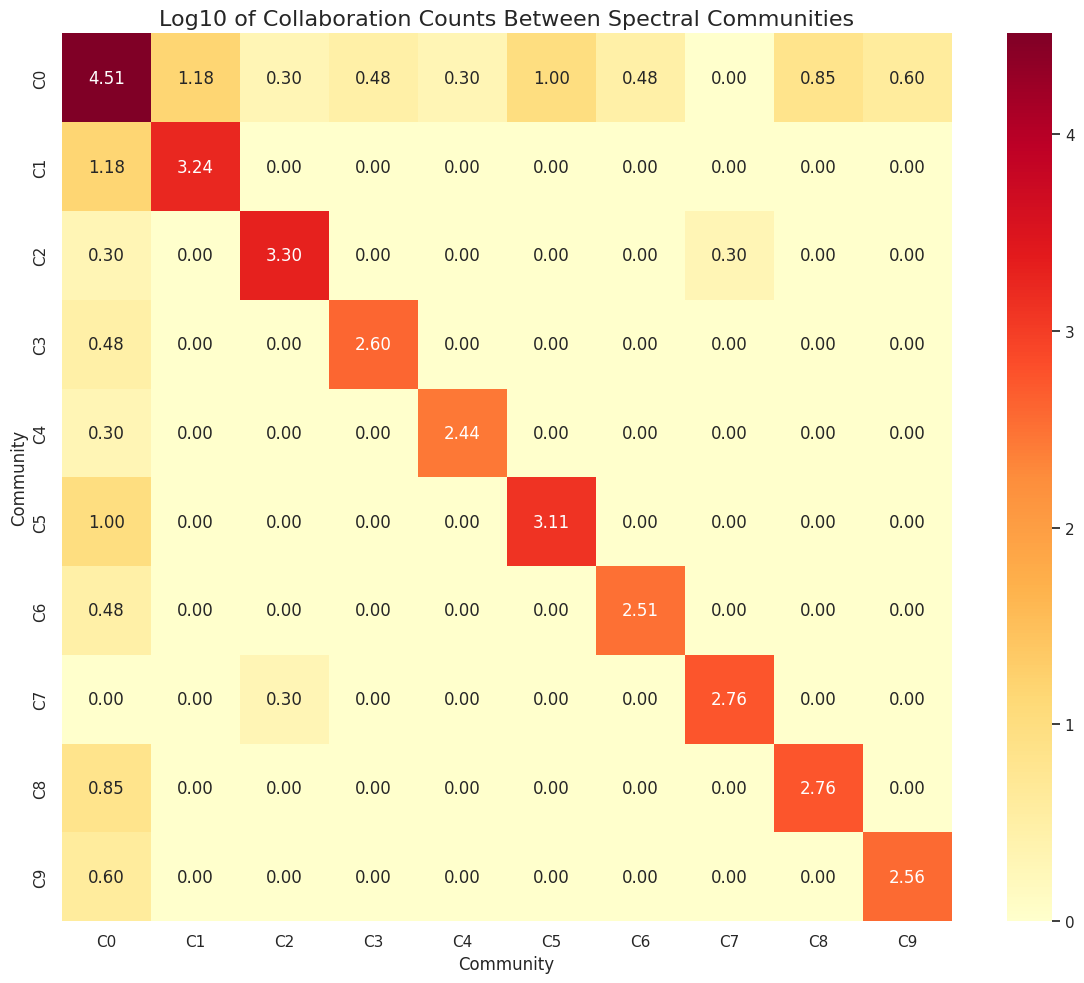

Creating collaboration pattern visualization for GMM communities...


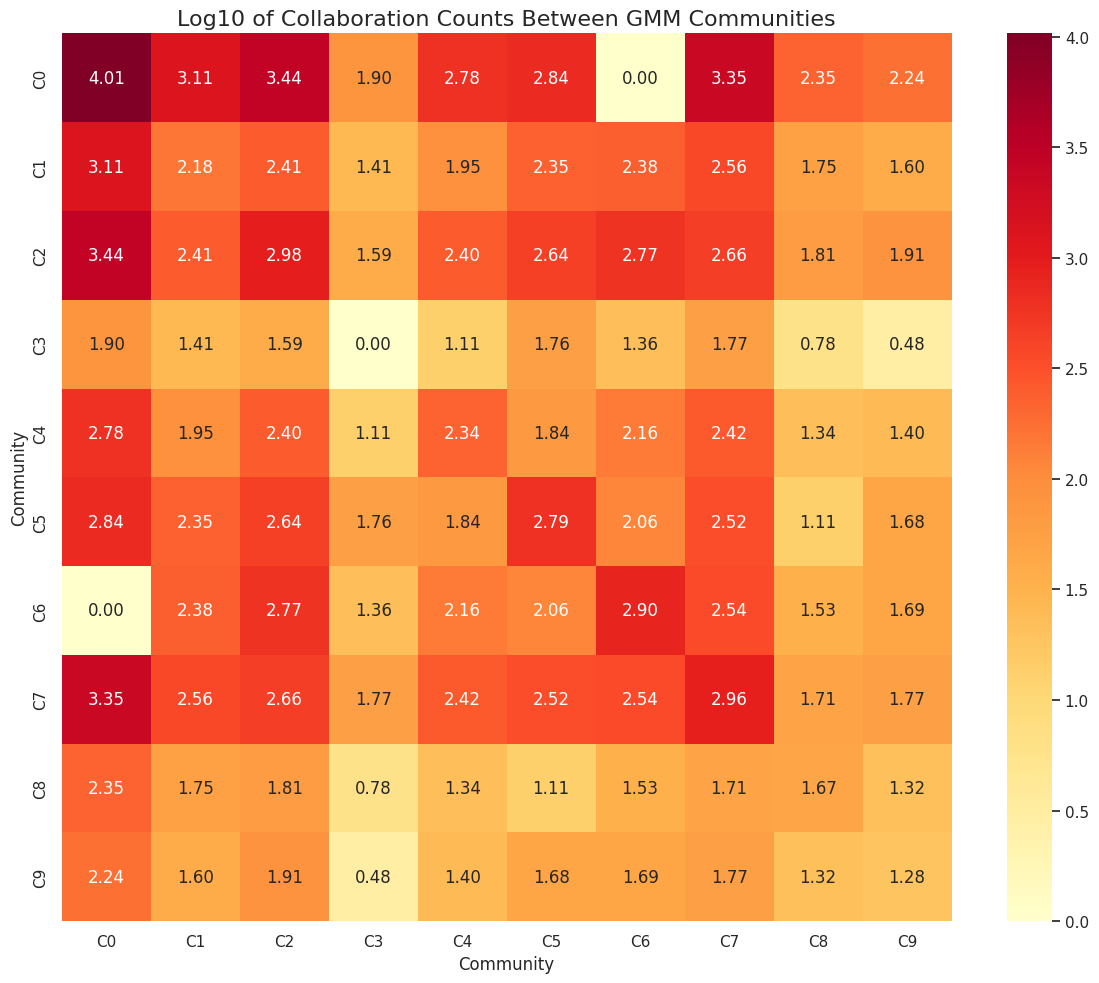

In [75]:
def visualize_collaboration_patterns(G, communities, method_name='Louvain'):
    """
    Visualize collaboration patterns within and between communities
    """
    print(f"Creating collaboration pattern visualization for {method_name} communities...")
    
    # Get unique communities
    unique_communities = sorted(set(communities.values()))
    num_communities = len(unique_communities)
    
    # Create a mapping from community id to index
    comm_to_idx = {comm: i for i, comm in enumerate(unique_communities)}
    
    # Initialize collaboration matrix
    collab_matrix = np.zeros((num_communities, num_communities))
    
    # Count collaborations within and between communities
    for u, v, data in G.edges(data=True):
        if u in communities and v in communities:
            u_comm = communities[u]
            v_comm = communities[v]
            
            # Get indices
            u_idx = comm_to_idx[u_comm]
            v_idx = comm_to_idx[v_comm]
            
            # Add edge weight to matrix
            weight = data.get('weight', 1)
            collab_matrix[u_idx, v_idx] += weight
            collab_matrix[v_idx, u_idx] += weight  # Symmetric for undirected graph
    
    # Create a dataframe
    collab_df = pd.DataFrame(collab_matrix, 
                           index=[f'C{comm}' for comm in unique_communities], 
                           columns=[f'C{comm}' for comm in unique_communities])
    
    # Visualize as heatmap
    plt.figure(figsize=(12, 10))
    
    # Use log scale for better visualization if there's high variance
    if collab_matrix.max() / (collab_matrix[collab_matrix > 0].min() + 1e-10) > 100:
        # Add small value to avoid log(0)
        collab_matrix_log = np.log10(collab_matrix + 1)
        sns.heatmap(collab_matrix_log, cmap='YlOrRd', annot=True, fmt='.2f',
                   xticklabels=collab_df.columns, yticklabels=collab_df.index)
        plt.title(f'Log10 of Collaboration Counts Between {method_name} Communities', fontsize=16)
    else:
        sns.heatmap(collab_df, cmap='YlOrRd', annot=True, fmt='.0f')
        plt.title(f'Collaboration Counts Between {method_name} Communities', fontsize=16)
    
    plt.xlabel('Community')
    plt.ylabel('Community')
    plt.tight_layout()
    plt.savefig(f'{method_name.lower()}_collaboration_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
# Visualize collaboration patterns for each clustering method
visualize_collaboration_patterns(G_filtered, spectral_clusters, method_name='Spectral')
visualize_collaboration_patterns(G_filtered, gmm_clusters, method_name='GMM')